dataset: https://drive.google.com/file/d/18aMf57_1u2AWInnMB67s3Xku0sPzm28u/view

# B1. Import các thư viện cần thiết

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import time
import copy
import warnings
from tqdm import tqdm


#for Data preprocessing and Augmentation
import os
from imutils import paths
import cv2
# import Augmentor
import torchvision.transforms as transforms

# from sklearn.preprocessing import OneHotEncoder

#for reading and displaying images
import matplotlib.pyplot as plt
from PIL import Image

#Pytorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split

#torchvision for pre-trained models
import torchvision
from torchvision import datasets, models

#for evaluating model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay


# B2. Dữ liệu đầu vào

# A. Khởi tạo giá trị các tham số

In [2]:
BATCH_SIZE = 32
classes = ['Normal', 'Covid']
num_classes = 2
num_epochs = 15
criterion = CrossEntropyLoss()
CHECKPOINT_PATH = '../MODEL/FT_VGG16.pt'
path_dataset = '/media/trucloan/Data/Research/TransferLearningVGG19bnCovid1910k_images/dataset10K_images/'

std = np.array([0.229, 0.224, 0.225])
mean = np.array([0.485, 0.456, 0.406])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

# B. Đường dẫn đến tập dữ liệu

In [3]:
normal = path_dataset + 'NORMAL/'
covid = path_dataset + 'COVID/'

dir_normal = os.listdir(normal)
dir_covid = os.listdir(covid)


dict_data0 = {'path': normal, 'image_name': dir_normal, 'labels': 0}
dict_data1 = {'path': covid, 'image_name': dir_covid, 'labels': 1}


In [4]:
df0 = pd.DataFrame(dict_data0)
df1 = pd.DataFrame(dict_data1)
df = pd.concat([df0, df1])
df.to_csv('./data.csv', index = False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        10000 non-null  object
 1   image_name  10000 non-null  object
 2   labels      10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 312.5+ KB


In [6]:
train_data, test_data=train_test_split(df, test_size=0.2, random_state = 42, shuffle=True)
train_data, val_data =train_test_split(train_data, test_size=0.2, random_state = 42, shuffle=True)

In [7]:
print(len(train_data), len(val_data), len(test_data))

6400 1600 2000


# C. Định nghĩa lớp dataset

In [8]:
class ImageDataset(Dataset):
    def __init__(self, csv, transform):
        self.transform = transform
        self.csv = csv
        
        self.image_name = self.csv[:]['image_name']
        self.label = np.array(self.csv[:]['labels'])
    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index): 
        images = Image.open(self.csv['path'].iloc[index] + self.image_name.iloc[index]).convert('RGB')
        
        images = self.transform(images)
        targets = self.label[index]
        targets = torch.tensor(targets, dtype = torch.long)
#         sample = {'image': image, 'labels': targets}
        
        return images, targets
        

# D. Biến đổi và đưa dữ liệu vào mô hình huấn luyện theo batch

In [9]:
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((224,224)),    
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = ImageDataset(train_data, transform)
val_dataset = ImageDataset(val_data, transform)
test_dataset = ImageDataset(test_data, transform)

train_dataset

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

# B3. Định nghĩa hàm train model (sử dụng  Early Stopping)

In [11]:
def training_loop(model, optimizer, loss_list, acc_list):
    model.to(device)
    #List to store loss to visualize
    lossli = loss_list
    accli = acc_list
    
    y_true = []
    y_pred = []
    
    valid_loss_min = np.Inf # track change in validation loss
    count = 0
    patience = 8 # nếu val_loss tăng 15 lần thì ngừng
    for epoch in range(num_epochs):
        
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0.0
        valid_acc = 0.0
        
        ###################
        # train the model #
        ###################
        
        model.train()
        for data, label in tqdm(train_dataloader):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
        
            
            train_loss += loss.item()*data.size(0)
            
            _, pred = torch.max(output, 1)              
            
            train_acc += pred.eq(label).sum().item()
            
#         scheduler.step() ###########
            
        ######################
        # validate the model #
        ######################
        
        model.eval()
        with torch.no_grad():
            for data, label in tqdm(val_dataloader):
                data = data.to(device)
                label = label.to(device)
                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item()*data.size(0)
                
                # Calculate accuracy
                _, pred = torch.max(output, 1)
#                 y_true += target.tolist()
#                 y_pred += pred.tolist()  
                
                valid_acc +=  pred.eq(label).sum().item()
       
        # calculate average losses
        train_loss = train_loss/len(train_dataloader.dataset)
        valid_loss = valid_loss/len(val_dataloader.dataset)
        lossli.append({'epoch':epoch,'train_loss': train_loss,'valid_loss':valid_loss})
        
        train_acc = train_acc*100/len(train_dataloader.dataset)
        valid_acc = valid_acc*100/len(val_dataloader.dataset)
        accli.append({'epoch':epoch,'train_acc': train_acc,'valid_acc':valid_acc})
        
        ####################
        # Early stopping #
        ##################
        
        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n \tTraining Acc: {:.6f} \tValidation Acc: {:.6f}'.format(
            epoch, train_loss, valid_loss, train_acc, valid_acc))
        # save model if validation loss has decreased
       
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_acc': accli,
            'loss_list': lossli,
            'loss': loss
            }, CHECKPOINT_PATH)
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            
            count = 0
            print('count = ',count)
            torch.save(model, '../MODEL/FTVGG16_model.pt') #save model 
                                  
            valid_loss_min = valid_loss
        else:
            count += 1
            print('count = ',count)
            if count >= patience:
                print('Early stopping!')
   
                return lossli, accli    
           
    return lossli, accli

# B4. Đặt thuộc tính .requires_grad của các tham số trong model

In [12]:
def set_parameter_requires_grad (model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# B5. Khởi tạo và reshape model

In [13]:
def initialize_model(num_classes, feature_extract, use_pretrained = True):
    model_ft = models.vgg16(pretrained = use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained = True)

print (model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# B6. Sử dụng hàm tối ưu

In [14]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = Adam(params_to_update ,lr = 0.001, weight_decay=1e-5)


Params to learn:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


# B7. Chạy các bước huấn luyện và kiểm định mô hình

In [15]:
loss_list, acc_list = [],[]

since = time.time()

loss, acc = training_loop(
    model = model_ft,
    optimizer = optimizer,
    loss_list = loss_list,
    acc_list = acc_list
)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Epoch: 0 	Training Loss: 0.681764 	Validation Loss: 0.368390 
 	Training Acc: 73.828125 	Validation Acc: 83.437500
Validation loss decreased (inf --> 0.368390). Saving model ...
count =  0


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch: 1 	Training Loss: 0.270367 	Validation Loss: 0.218378 
 	Training Acc: 89.046875 	Validation Acc: 89.562500
Validation loss decreased (0.368390 --> 0.218378). Saving model ...
count =  0


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


Epoch: 2 	Training Loss: 0.196805 	Validation Loss: 0.164729 
 	Training Acc: 92.437500 	Validation Acc: 93.000000
Validation loss decreased (0.218378 --> 0.164729). Saving model ...
count =  0


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Epoch: 3 	Training Loss: 0.154029 	Validation Loss: 0.111642 
 	Training Acc: 94.140625 	Validation Acc: 95.625000
Validation loss decreased (0.164729 --> 0.111642). Saving model ...
count =  0


100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


Epoch: 4 	Training Loss: 0.147173 	Validation Loss: 0.177713 
 	Training Acc: 94.578125 	Validation Acc: 93.625000


  0%|          | 0/200 [00:00<?, ?it/s]

count =  1


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch: 5 	Training Loss: 0.140728 	Validation Loss: 0.102832 
 	Training Acc: 95.140625 	Validation Acc: 96.125000
Validation loss decreased (0.111642 --> 0.102832). Saving model ...
count =  0


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch: 6 	Training Loss: 0.100500 	Validation Loss: 0.084880 
 	Training Acc: 96.593750 	Validation Acc: 96.375000
Validation loss decreased (0.102832 --> 0.084880). Saving model ...
count =  0


100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


Epoch: 7 	Training Loss: 0.226790 	Validation Loss: 0.158864 
 	Training Acc: 92.234375 	Validation Acc: 93.812500


  0%|          | 0/200 [00:00<?, ?it/s]

count =  1


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch: 8 	Training Loss: 0.213245 	Validation Loss: 0.131379 
 	Training Acc: 93.484375 	Validation Acc: 94.562500


  0%|          | 0/200 [00:00<?, ?it/s]

count =  2


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


Epoch: 9 	Training Loss: 0.096975 	Validation Loss: 0.092086 
 	Training Acc: 96.687500 	Validation Acc: 96.250000


  0%|          | 0/200 [00:00<?, ?it/s]

count =  3


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch: 10 	Training Loss: 0.094972 	Validation Loss: 0.090313 
 	Training Acc: 96.640625 	Validation Acc: 96.500000


  0%|          | 0/200 [00:00<?, ?it/s]

count =  4


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch: 11 	Training Loss: 0.060679 	Validation Loss: 0.091619 
 	Training Acc: 97.703125 	Validation Acc: 96.500000


  0%|          | 0/200 [00:00<?, ?it/s]

count =  5


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Epoch: 12 	Training Loss: 0.092600 	Validation Loss: 0.124355 
 	Training Acc: 96.968750 	Validation Acc: 96.562500


  0%|          | 0/200 [00:00<?, ?it/s]

count =  6


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch: 13 	Training Loss: 0.056908 	Validation Loss: 0.070447 
 	Training Acc: 98.140625 	Validation Acc: 97.187500
Validation loss decreased (0.084880 --> 0.070447). Saving model ...
count =  0


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


Epoch: 14 	Training Loss: 0.045501 	Validation Loss: 0.124809 
 	Training Acc: 98.375000 	Validation Acc: 96.312500
count =  1
Training complete in 51m 2s


# load model, state_dict

In [16]:
checkpoint = torch.load(CHECKPOINT_PATH)#, map_location=device)
model_ft.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_list = checkpoint['loss_list']
acc_list = checkpoint['train_acc']

/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


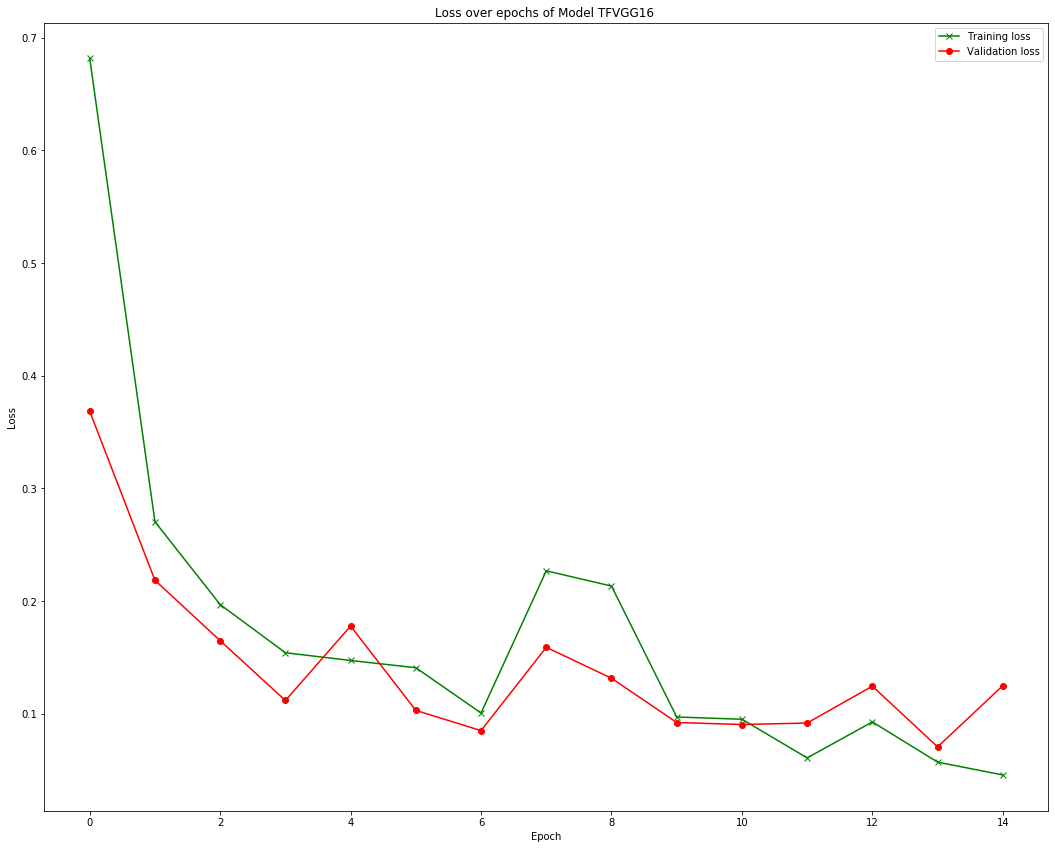

In [17]:
#ve do thi loss (train, val)
def visualize_loss (checkpoint, path_loss):
    loss = checkpoint['loss_list'] 
    train_loss = [x['train_loss'] for x in loss]
    valid_loss = [x['valid_loss'] for x in loss]
    fig, ax = plt.subplots(figsize = (18, 14.5))
    ax.plot(train_loss, '-gx', label='Training loss')
    ax.plot(valid_loss , '-ro', label='Validation loss')
    ax.set(title="Loss over epochs of Model TFVGG16 ",
    xlabel='Epoch',
    ylabel='Loss')
    ax.legend()
    fig.show()
    plt.savefig(path_loss)
visualize_loss(checkpoint, '../REPORT/lossTFVGG16.png')

/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


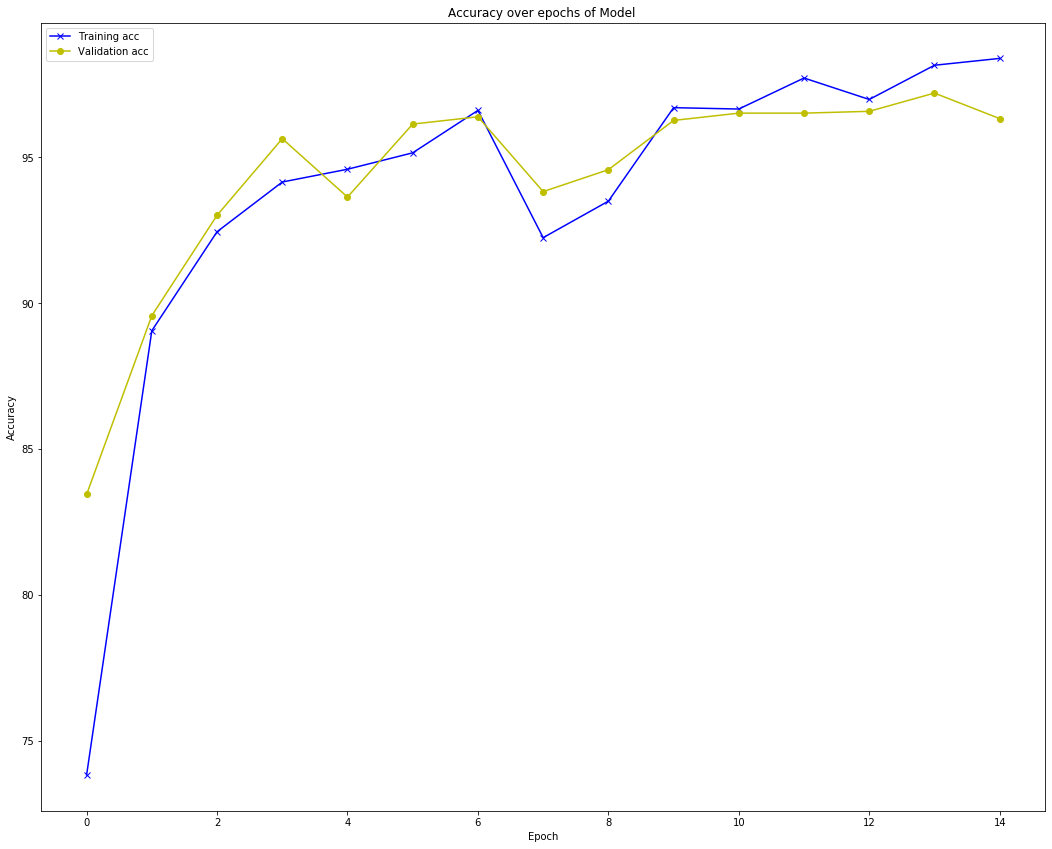

In [18]:
#ve do thi acc (train, val)
def visualize_acc (checkpoint, path_acc):
    acclist = checkpoint['train_acc'] #
    train_acc = [x['train_acc'] for x in acclist]
    valid_acc = [x['valid_acc'] for x in acclist]
    fig, ax = plt.subplots(figsize = (18, 14.5))
    ax.plot(train_acc, '-bx', label='Training acc')
    ax.plot(valid_acc , '-yo', label='Validation acc')
    ax.set(title="Accuracy over epochs of Model ",
    xlabel='Epoch',
    ylabel='Accuracy')
    ax.legend()
    fig.show()
    plt.savefig(path_acc)
visualize_acc(checkpoint, '../REPORT/AccuracyFTVGG16.png')

In [19]:
#test model
def test_loop():
    with torch.no_grad():
        y_true = []
        y_pred = []
        model_ft.to(device)
        model_ft.eval()
        for data, target in test_dataloader:
            batch_size = data.size(0)
            data = data.to(device)
            target = target.to(device)
            output = model_ft(data)
            _,pred = torch.max(output, 1)
            y_true += target.tolist()
            y_pred += pred.tolist()
    return y_true, y_pred


y_true, y_pred = test_loop()
        

In [20]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.961

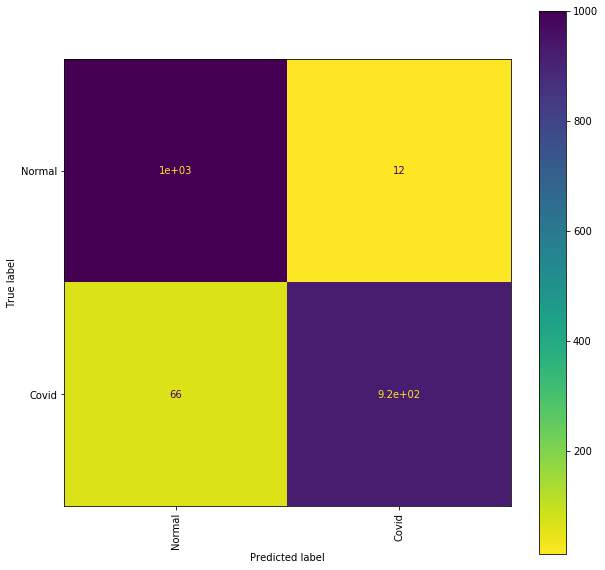

In [21]:
cnf_matrix = confusion_matrix(y_true, y_pred)
fix, ax = plt.subplots(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels = classes)
disp.plot(include_values = True, cmap = 'viridis_r', ax = ax, xticks_rotation = 'vertical')
plt.savefig('../REPORT/MatrixFTVGG16.png')

In [22]:
path_rp = '../REPORT/report_FTVGG16.txt'
try:
    s = classification_report(y_true, y_pred, target_names = classes)
    with open(path_rp, mode ='x') as f:
        f.write(s)
    with open(path_rp) as f:
        print(f.read())
    f.close()
except FileExistsError:
    pass

              precision    recall  f1-score   support

      Normal       0.94      0.99      0.96      1012
       Covid       0.99      0.93      0.96       988

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [23]:
# Predict images
def img_transform(path_img):
    img = Image.open(path_img)
    imagetensor = transform(img).cuda()
    return imagetensor

def predict(path_img, verbose = False):
    if not verbose:
        warnings.filterwarnings('ignore')
    try:
        checks_if_model_is_loaded = type(model)
    except:
        pass
    model_ft.eval()
    if verbose:
        print('Model loader ...')
    image = img_transform(path_img)
    image1 = image[None,:,:,:]
    
    with torch.no_grad():
        outputs = model_ft(image1)
        
        _,pred_int = torch.max(outputs.data, 1)
        _,top1_idx = torch.topk(outputs.data, 1, dim = 1)
        pred_idx = int(pred_int.cpu().numpy())
        if pred_idx == 0:
            pred_str = str('Negative')
            print('img: {} is: {}'.format(os.path.basename(path_img), pred_str))
        else:
            pred_str = str('Positive')
            print('img: {} is: {}'.format(os.path.basename(path_img), pred_str))
            
    

img: covid.jpg is: Positive


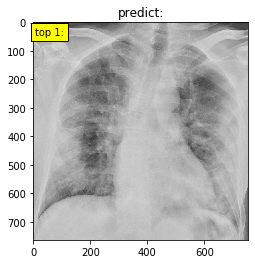

In [24]:
pred_str = str('')
path_image = '/media/trucloan/Data/Research/TransferLearningVGG19bnCovid1910k_images//pred/covid.jpg'

img = Image.open(path_image)
plt.imshow(img)

predict(path_image)
plt.title('predict:{}'.format(pred_str))
plt.text(5,45,'top {}:{}'.format(1,pred_str), bbox = dict(fc='yellow'))
plt.show()